## 2. Setup: Initialize environment and client

In [6]:
import json
import display_functions
from dotenv import load_dotenv
_ = load_dotenv()

### 2.1 Getting started with AISuite

In [7]:
import aisuite as ai

# Create an instance of the AISuite client
client = ai.Client()

## 3. Build your first tool

### 3.1 Defining your function

In [8]:
from datetime import datetime

def get_current_time():
    """
    Returns the current time as a string.
    """
    return datetime.now().strftime("%H:%M:%S")

Test out your function to what exactly this function returns.

<div style="background-color:#ffe4e1; padding:12px; border-radius:6px; color:black;">
  <strong>Note:</strong> The DeepLearning.AI platform uses Greenwich Mean Time (GMT) by default. If you run this function locally, it will return your local time instead.
</div>

In [9]:
get_current_time()

'15:51:06'

### 3.2 Turning your function into an LLM tool

构建与 LLM 的对话结构，让它能够调用你注册的工具。

* 创建一个标准的消息格式

In [10]:
# Message structure
prompt = "What time is it?"
messages = [
    {
        "role": "user",
        "content": prompt,
    }
]

* 构造一次完整的对话调用（chat completion），让 LLM 参与决策、调用工具，并生成回答。

In [11]:
response = client.chat.completions.create(
    model="deepseek:deepseek-chat",
    messages=messages,
    tools=[get_current_time],
    max_turns=5
)

# See the LLM response
print(response.choices[0].message.content)

The current time is 15:51:09 (3:51 PM).


### 3.3 Taking a closer look at the response

用辅助函数 pretty_print_chat_completion 来可视化 LLM 的思考过程和工具调用细节。

In [12]:
display_functions.pretty_print_chat_completion(response)

### 3.4 Manually defining tools

手动定义工具的 schema（结构化描述）

> 🧪 为什么要手动定义？
>
> 虽然 AISuite 可以自动从函数推断出工具结构（通过装饰器和 docstring），但手动定义有几个优势：
>
> ✅ 更精细控制工具描述（可以写更详细的提示）
>
> ✅ 可以动态构造工具列表（比如根据用户权限或上下文）
>
> ✅ 可以与非 Python 函数集成（如远程 API）

让 LLM 生成调用请求，但由你来识别并执行工具，然后再把结果反馈给 LLM。

In [13]:
tools = [{
    "type": "function",
    "function": {
        "name": "get_current_time",
        "description": "Returns the current time as a string.",
        "parameters": {
            "type": "object",
            "properties": {}
        }
    }
}]


In [14]:
response = client.chat.completions.create(
    model="deepseek:deepseek-chat",
    messages=messages,
    tools=tools, # <-- Your list of tools with get_current_time
    # max_turns=5 # <-- When defining tools manually, you must handle calls yourself and cannot use max_turns
)

In [15]:
print(json.dumps(response.choices[0].message.model_dump(), indent=2, default=str))

{
  "content": "I'll check the current time for you.",
  "reasoning_content": null,
  "tool_calls": [
    {
      "id": "call_00_zGvVw79IgwpSSV4Fs9fJUNl2",
      "function": {
        "arguments": "{}",
        "name": "get_current_time"
      },
      "type": "function"
    }
  ],
  "role": "assistant",
  "refusal": null
}


In [16]:
response2 = None

# Create a condition in case tool_calls is in response object
if response.choices[0].message.tool_calls:
    # Pull out the specific tool metadata from the response
    tool_call = response.choices[0].message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)

    # Run the tool locally
    tool_result = get_current_time()

    # Append the result to the messages list
    messages.append(response.choices[0].message)
    messages.append({
        "role": "tool", "tool_call_id": tool_call.id, "content": str(tool_result)
    })

    # Send the list of messages with the newly appended results back to the LLM
    response2 = client.chat.completions.create(
        model="deepseek:deepseek-chat",
        messages=messages,
        tools=tools,
    )

    print(response2.choices[0].message.content)


The current time is 15:51:12.


## 4. Giving the LLM more tools

### 4.1 Three new tools

You will define three new tools for your LLM:

- **Weather Tool (`get_weather_from_ip`)**
  Detects the user’s location and returns the current, the high, and the low temperature using external API calls to detect your IP address and then send that to a weather API to get the current weather.

- **File Writing Tool (`write_txt_file`)**
  Creates a text file with the specified content in your local environment. The function takes two arguments, `file_path` and `content`.

- **QR Code Generator (`generate_qr_code`)**
  Generates a QR code image from data, with optional image embedding. The function takes three arguments: `data`, `filename`, and `img_path`.


In [ ]:
import requests
import qrcode
from qrcode.image.styledpil import StyledPilImage


def get_weather_from_ip():
    """
    Gets the current, high, and low temperature in Fahrenheit for the user's
    location and returns it to the user.
    """
    # Get location coordinates from the IP address
    lat, lon = requests.get('https://ipinfo.io/json').json()['loc'].split(',')

    # Set parameters for the weather API call
    params = {
        "latitude": lat,
        "longitude": lon,
        "current": "temperature_2m",
        "daily": "temperature_2m_max,temperature_2m_min",
        "temperature_unit": "fahrenheit",
        "timezone": "auto"
    }

    # Get weather data
    weather_data = requests.get("https://api.open-meteo.com/v1/forecast", params=params).json()

    # Format and return the simplified string
    return (
        f"Current: {weather_data['current']['temperature_2m']}°F, "
        f"High: {weather_data['daily']['temperature_2m_max'][0]}°F, "
        f"Low: {weather_data['daily']['temperature_2m_min'][0]}°F"
    )

# Write a text file
def write_txt_file(file_path: str, content: str):
    """
    Write a string into a .txt file (overwrites if exists).
    Args:
        file_path (str): Destination path.
        content (str): Text to write.
    Returns:
        str: Path to the written file.
    """
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)
    return file_path


# Create a QR code
def generate_qr_code(data: str, filename: str, image_path: str):
    """Generate a QR code image given data and an image path.

    Args:
        data: Text or URL to encode
        filename: Name for the output PNG file (without extension)
        image_path: Path to the image to be used in the QR code
    """
    qr = qrcode.QRCode(error_correction=qrcode.constants.ERROR_CORRECT_H)
    qr.add_data(data)

    img = qr.make_image(image_factory=StyledPilImage, embedded_image_path=image_path)
    output_file = f"{filename}.png"
    img.save(output_file)

    return f"QR code saved as {output_file} containing: {data[:50]}..."

### 4.2 Using your new tools

Let's start with the `get_weather_from_ip` tool.

In [19]:
prompt = "Can you get the weather for my location?"

response = client.chat.completions.create(
    model="deepseek:deepseek-chat",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

Now, run the cell below to prompt the LLM to create a note for you.

In [24]:
prompt = "Please create a file called reminders.txt in the current directory that says 'Call Daniel tomorrow at 7PM'."

response = client.chat.completions.create(
    model="deepseek:deepseek-chat",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

Open the file and read its contents.

In [25]:
with open('reminders.txt', 'r') as file:
    contents = file.read()
    print(contents)

Call Daniel tomorrow at 7PM


Run the cell below to create the QR code.

In [27]:
prompt = "Can you make a QR code for me using my company's logo that goes to www.deeplearning.ai? The logo is located at `dl_logo.jpg`. You can call it dl_qr_code."

response = client.chat.completions.create(
    model="dashscope:qwen3-max",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

Take a look at the QR by running the cell below and try it out to see if it works by taking you to the DeepLearning.AI website.

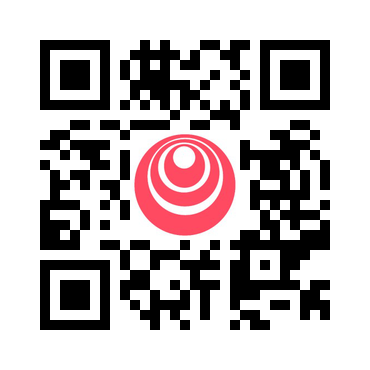

In [28]:
from IPython.display import Image, display

# Display image directly
Image('dl_qr_code.png')

### 4.3 Using multiple tools at once

use a complex prompt:

> Can you help me create a qr code that goes to www.deeplearning.com from the image dl_logo.jpg? Also write me a txt note with the current weather please.

Note: This prompt requires a good amount of logic to understand what to call and when. For example, although you ask it to write a text note first and then describe the contents, the LLM will need that information first to pass it to the text note. If the LLM asked to use `write_txt_file` first, it would not have the information from `get_weather_from_ip`. This is a good example of the power of LLMs to parse natural language and use appropriate tools in the right order to accomplish a wide variety of tasks.

<div style="background-color: #ffe4e1; padding: 12px; border-radius: 6px; color: black;">

<h4>🔍 What to Notice:</h4>

<ul>
  <li>The LLM <b>automatically chooses</b> which tool to use based on the user request</li>
  <li><b>Parameters are inferred</b> from the user's message (like file names, content, URLs)</li>
  <li>Each tool <b>returns information</b> that the LLM incorporates into its response</li>
  <li><b>No-parameter tools</b> like weather and time are perfect for quick information requests</li>
  <li>The conversation feels <b>natural</b> despite complex operations happening behind the scenes</li>
</ul>

</div>

In [29]:
prompt = "Can you help me create a qr code that goes to www.deeplearning.com from the image dl_logo.jpg? Also write me a txt note with the current weather please."

response = client.chat.completions.create(
    model="dashscope:qwen3-max",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_weather_from_ip,
        get_current_time,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=10
)

display_functions.pretty_print_chat_completion(response)

### Model Options

You can experiment with different OpenAI models when running these tool-calling workflows. Each model offers a different balance of capability, cost, and speed:

- **`openai:gpt-4o`** — optimized for reasoning and speed
- **`openai:gpt-4.1`** — strong reasoning performance, good for complex tasks
- **`openai:gpt-4.1-mini`** — lighter, faster, and cheaper than full GPT-4.1
- **`openai:gpt-3.5-turbo`** — efficient for simpler tasks and quick iterations

Choosing a model depends on your goals:
- Use smaller models for fast, low-cost prototyping
- Switch to stronger models when tasks require better reasoning or multi-step orchestration


### Final Takeaways

- Tool calling lets LLMs go beyond text generation—they can now use functions as part of their reasoning.
- Clear, well-documented functions (with precise docstrings) help the model know when and how to use each tool.
- AISuite handles the complexity of translating python functions into tool schemas and orchestrating multi-step workflows.
- Choosing the right model matters: smaller models are faster and cheaper for simple tasks, while stronger models are better for reasoning-heavy workflows.
- Watching the conversation flow (prompts, tool calls, results, final response) is essential for debugging and improving agentic behaviors.

With these elements in place, you now have the foundation to design agents that combine LLM reasoning with external tools to complete more complex tasks.


## 🧠 Agentic Tool-Calling Behavior by Model

### 模型行为对比表

| 模型名称               | 工具调用风格         | 参数推理能力         | 示例行为                                                                 | 适配建议                                               |
|------------------------|----------------------|----------------------|--------------------------------------------------------------------------|--------------------------------------------------------|
| `deepseek:deepseek-chat` | 谨慎、明确确认       | ❌ 不假设路径         | 请求补充 `"file_path"` 后才调用 `write_txt_file`                         | 在 prompt 中明确路径，如 `"./reminders.txt"`           |
| `dashscope:qwen3-max`    | 主动、容错强         | ✅ 自动推理默认值     | 自动调用 `write_txt_file("./reminders.txt", "...")` 无需补充             | 可用自然语言描述意图，无需结构化                       |
| `openai:gpt-4o`          | 结构化、稳健         | ✅ 推理能力强         | 自动调用工具并生成最终回答                                               | 使用标准化语句，明确参数结构                           |
| `openai:o4-mini`         | 精简、偏保守         | ✅ 中等推理能力       | 有时不调用工具，或仅生成自然语言回应                                     | 使用明确任务描述和参数提示词                           |

---

### 📌 示例 Prompt 对比

| Prompt                                                                 | DeepSeek 行为               | Qwen 行为                     |
|------------------------------------------------------------------------|------------------------------|-------------------------------|
| `"Can you make a txt note for me called reminders.txt that reminds me to call Daniel tomorrow at 7PM?"` | 请求补充路径                 | 自动推理路径并调用工具         |
| `"Please create a file called reminders.txt in the current directory that says 'Call Daniel tomorrow at 7PM'"` | ✅ 成功推理并调用工具         | ✅ 同样成功                    |

---

### 🧩 总结建议

- 对于 **DeepSeek**，建议在 prompt 中明确路径、格式和目标，避免模型请求 clarification。
- 对于 **Qwen**，可以使用更自然的语言描述任务，它会主动推理合理参数。
- 对于 **OpenAI 系列模型**，结构化表达更稳定，尤其适合多步骤任务。
- 你可以根据模型风格封装 prompt 适配器，提升工具调用成功率。

